# Box Plots for journey times through BX

Import data, group by patient id etc .....

## Initialisation

Import dependencies, initialise some variables including loading in data. Files to import are based on filtered Ubisense "all rawdata" downloads. These are stored in the github folder "data" of this repo.

In [325]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
from google.colab import files

order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
fig_size = (16,10) # how big the exported figures should be - width, height - in inches!
ymax_boxplot = 240 # max scale on the box plots to normalise across phases

## Edit this section per run of data processing

In [326]:
# ------------------
# Edit these lines per run of data processing
# ------------------
#phase = 'P1' # edit which Phase you are analysing - this is used in graph and file generation
#p_start_date = dt.date(2021, 10, 11) # YYYY, MM, DD
#p_end_date = dt.date(2021, 11, 12)
#phase = 'P2' # edit which Phase you are analysing - this is used in graph and file generation
#p_start_date = dt.date(2021, 11, 30) # YYYY, MM, DD
#p_end_date = dt.date(2022, 1, 28)
#phase = 'P3' # edit which Phase you are analysing - this is used in graph and file generation
#p_start_date = dt.date(2022, 2, 23) # YYYY, MM, DD
#p_end_date = dt.date(2022, 5, 6)
phase = 'P4' # edit which Phase you are analysing - this is used in graph and file generation
p_start_date = dt.date(2022, 9, 7) # YYYY, MM, DD
p_end_date = dt.date(2023, 3, 1)
# ------------------

# read in CSV data
df = pd.read_csv('{}_input.csv'.format(phase))
# convert dates into ones that can be used in pandas
df['starttime'] = pd.to_datetime(df['starttime']) # datetime in YYYY-MM-DD HH:MM:SS format
df['endtime'] = pd.to_datetime(df['endtime'])

df.sort_values(by='starttime', inplace = True) 
df # check what column headings in file

,Patient,Location,starttime,endtime,xlocation,ylocation,step_length
140592,R1970,"17.983,15.578",2022-09-07 10:35:55,2022-09-07 10:36:02,17.9830,15.5780,0 days 00:00:07
140593,R1970,"10.786,16.219",2022-09-07 10:36:02,2022-09-07 10:36:05,10.7860,16.2190,0 days 00:00:03
140594,R1970,"9.822,16.789",2022-09-07 10:36:05,2022-09-07 10:36:27,9.8220,16.7890,0 days 00:00:22
140595,R1970,"8.042,10.872",2022-09-07 10:36:27,2022-09-07 10:38:37,8.0420,10.8720,0 days 00:02:10
140596,R1970,"8.22,9.716",2022-09-07 10:38:37,2022-09-07 10:38:51,8.2200,9.7160,0 days 00:00:14
...,...,...,...,...,...,...,...
140185,G3212,"4.312,4.614",2023-02-27 13:02:14,2023-02-27 13:02:15,4.3120,4.6140,0 days 00:00:01
140186,G3212,"4.96,5.566",2023-02-27 13:02:15,2023-02-27 13:02:15,4.9600,5.5660,0 days 00:00:00
140187,G3212,"4.926,6.526",2023-02-27 13:02:15,2023-02-27 13:02:27,4.9260,6.5260,0 days 00:00:12
140188,G3212,"3.987,4.14",2023-02-27 13:02:27,2023-02-27 13:02:28,3.9870,4.1400,0 days 00:00:01


In [327]:
# check the start and end dates of the phase being reported yyyy-mmm-dd
print("Earliest Date: ", df.starttime.min())
print("Latest Date:   ", df.endtime.max())

Earliest Date:  2022-09-07 10:35:55
Latest Date:    2023-02-27 13:02:33


In [328]:
print(df[df['starttime'] < pd.to_datetime(p_start_date)])
print(df[df['endtime'] > pd.to_datetime(p_end_date)])
df = df.drop(df[df['starttime'] < pd.to_datetime(p_start_date)].index)
df = df.drop(df[df['endtime'] > pd.to_datetime(p_end_date)].index)


Empty DataFrame
Columns: [Patient, Location, starttime, endtime, xlocation, ylocation, step_length]
Index: []
Empty DataFrame
Columns: [Patient, Location, starttime, endtime, xlocation, ylocation, step_length]
Index: []


In [329]:
print(df[df['starttime'] < pd.to_datetime(p_start_date)])
print(df[df['endtime'] > pd.to_datetime(p_end_date)])

Empty DataFrame
Columns: [Patient, Location, starttime, endtime, xlocation, ylocation, step_length]
Index: []
Empty DataFrame
Columns: [Patient, Location, starttime, endtime, xlocation, ylocation, step_length]
Index: []


# Create a new dataframe to group each patient id - df_final

The code belows gets the earliest and latest times from a patient allowing the total journey time to be tracked. 

In [330]:
dfgrouped = df.groupby('Patient', as_index = False).agg(
    {'starttime': ['min'], 'endtime': ['max'], 'xlocation': ['first'], 'ylocation': ['first']})
dfgrouped.head()

,Patient,starttime,endtime,xlocation,ylocation
,,min,max,first,first
0,C0018,2022-09-20 10:23:24,2022-09-20 12:03:19,19.0810,15.8910
1,C0019,2022-09-20 10:27:50,2022-09-20 11:46:02,19.2260,16.8460
2,C0020,2022-09-20 10:33:07,2022-09-20 12:16:28,19.2900,15.8190
3,C0021,2022-09-20 10:41:53,2022-09-20 12:43:33,19.1800,15.9590
4,C0022,2022-09-20 10:46:32,2022-09-20 13:11:30,18.6480,14.9420


The code below changes column headers and continues to format and clean the data for subsequent analysis.

In [331]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]) # take the first element of the column heading only (ie ignore min, max, first)
dfgrouped.columns = flat_cols

Add in length of journey to each grouped patient id

In [332]:
dfgrouped['visit_length'] = dfgrouped['endtime'] - dfgrouped['starttime']

In [333]:
print(dfgrouped[dfgrouped['visit_length'] > pd.Timedelta(1, 'd')]) # this should return no results!

Empty DataFrame
Columns: [Patient, starttime, endtime, xlocation, ylocation, visit_length]
Index: []


In [334]:
dfgrouped['visit_length'].describe()

count                          924
mean     0 days 01:31:04.729437229
std      0 days 00:42:18.448214855
min                0 days 00:16:03
25%                0 days 00:58:18
50%         0 days 01:22:57.500000
75%         0 days 01:54:20.250000
max                0 days 04:45:19
Name: visit_length, dtype: object

Add in a day of week column value.

In [335]:
dfgrouped['dayofweek'] = dfgrouped['starttime'].dt.day_name()
df_final= dfgrouped.dropna()
df_final

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek
0,C0018,2022-09-20 10:23:24,2022-09-20 12:03:19,19.0810,15.8910,0 days 01:39:55,Tuesday
1,C0019,2022-09-20 10:27:50,2022-09-20 11:46:02,19.2260,16.8460,0 days 01:18:12,Tuesday
2,C0020,2022-09-20 10:33:07,2022-09-20 12:16:28,19.2900,15.8190,0 days 01:43:21,Tuesday
3,C0021,2022-09-20 10:41:53,2022-09-20 12:43:33,19.1800,15.9590,0 days 02:01:40,Tuesday
4,C0022,2022-09-20 10:46:32,2022-09-20 13:11:30,18.6480,14.9420,0 days 02:24:58,Tuesday
...,...,...,...,...,...,...,...
919,R2326,2023-02-24 11:36:16,2023-02-24 13:10:16,1.7410,2.6760,0 days 01:34:00,Friday
920,R2327,2023-02-24 11:47:32,2023-02-24 13:09:34,0.8860,2.1010,0 days 01:22:02,Friday
921,R2328,2023-02-27 10:50:44,2023-02-27 11:43:19,2.0070,2.3340,0 days 00:52:35,Monday
922,R2329,2023-02-27 11:09:15,2023-02-27 11:58:34,4.9260,6.5260,0 days 00:49:19,Monday


In [336]:
numberofdays = (df_final['starttime'] - pd.to_datetime(p_start_date)).dt.days
df_final['daynumber'] = numberofdays + 1 # adding one since counts from zero
df_final['weeknumber'] = (numberofdays // 7) + 1 # adding one since counts from zero
df_final

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber
0,C0018,2022-09-20 10:23:24,2022-09-20 12:03:19,19.0810,15.8910,0 days 01:39:55,Tuesday,14,2
1,C0019,2022-09-20 10:27:50,2022-09-20 11:46:02,19.2260,16.8460,0 days 01:18:12,Tuesday,14,2
2,C0020,2022-09-20 10:33:07,2022-09-20 12:16:28,19.2900,15.8190,0 days 01:43:21,Tuesday,14,2
3,C0021,2022-09-20 10:41:53,2022-09-20 12:43:33,19.1800,15.9590,0 days 02:01:40,Tuesday,14,2
4,C0022,2022-09-20 10:46:32,2022-09-20 13:11:30,18.6480,14.9420,0 days 02:24:58,Tuesday,14,2
...,...,...,...,...,...,...,...,...,...
919,R2326,2023-02-24 11:36:16,2023-02-24 13:10:16,1.7410,2.6760,0 days 01:34:00,Friday,171,25
920,R2327,2023-02-24 11:47:32,2023-02-24 13:09:34,0.8860,2.1010,0 days 01:22:02,Friday,171,25
921,R2328,2023-02-27 10:50:44,2023-02-27 11:43:19,2.0070,2.3340,0 days 00:52:35,Monday,174,25
922,R2329,2023-02-27 11:09:15,2023-02-27 11:58:34,4.9260,6.5260,0 days 00:49:19,Monday,174,25


# Analysis - df_final

Explore the "df_final" grouped data and make some intital plots.

## Day of the Week Analysis

In [337]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
dayoftheweekmean

dayofweek
Monday      0 days 01:25:50.380952380
Tuesday     0 days 01:36:04.597087378
Wednesday   0 days 01:25:38.742081447
Thursday       0 days 01:36:17.750000
Friday      0 days 01:31:49.681818181
Saturday                          NaT
Sunday                            NaT
Name: visit_length, dtype: timedelta64[ns]

## Week of Phase Analysis

In [338]:
weekofphasemean = df_final.groupby('weeknumber')['visit_length'].mean(numeric_only=False)
weekofphasemean

weeknumber
1    0 days 01:20:21.536842105
2    0 days 01:06:39.238095238
3    0 days 01:53:58.151515151
4       0 days 01:55:21.250000
5    0 days 02:11:18.433962264
6    0 days 01:30:57.061224489
7    0 days 01:21:29.372881355
8    0 days 01:32:53.611111111
9       0 days 02:06:00.950000
10   0 days 01:14:55.076923076
11   0 days 01:38:30.809523809
12   0 days 01:16:16.793103448
13   0 days 01:20:43.517241379
14   0 days 01:42:23.416666666
15   0 days 01:23:50.833333333
16   0 days 01:16:17.909090909
17      0 days 01:27:03.625000
18      0 days 01:31:52.750000
19   0 days 01:30:37.734693877
20   0 days 01:28:29.782608695
21   0 days 01:24:18.657894736
22      0 days 01:35:28.480000
23   0 days 01:48:07.928571428
24   0 days 01:26:42.869565217
25      0 days 01:32:39.200000
Name: visit_length, dtype: timedelta64[ns]

## Day of Phase Analysis

In [339]:
dayofphasemean = df_final.groupby('daynumber')['visit_length'].mean(numeric_only=False)
dayofphasemean

daynumber
1     0 days 01:21:56.111111111
2               0 days 00:56:35
6        0 days 01:17:35.440000
7        0 days 01:22:14.062500
8     0 days 00:57:49.193548387
9     0 days 00:55:32.952380952
10       0 days 00:53:30.150000
14    0 days 02:10:49.666666666
15    0 days 01:51:43.285714285
17    0 days 01:46:09.727272727
20       0 days 02:19:11.500000
21       0 days 01:36:58.500000
22       0 days 02:07:44.200000
23       0 days 02:59:22.400000
24    0 days 02:01:38.235294117
27       0 days 00:55:49.900000
28    0 days 02:02:26.866666666
29       0 days 01:41:49.500000
30    0 days 02:47:23.142857142
31    0 days 02:48:40.866666666
34    0 days 01:55:20.777777777
35       0 days 01:39:12.750000
36    0 days 01:25:40.666666666
37       0 days 00:49:43.500000
38    0 days 01:27:14.333333333
41    0 days 01:28:31.307692307
42    0 days 01:46:20.117647058
43    0 days 01:30:52.266666666
44    0 days 01:11:53.222222222
45    0 days 01:19:43.352941176
48    0 days 01:50:19.66666666


## Time of Day Analysis

Afternoon is defined as a journey starting from 13:00 onwards whereas any journey starting prior to 13:00 is defined as starting in the morning.

In [340]:
def ftod(x):
    if (x>12):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

df_final['tod'] = df_final.starttime.dt.hour.map(ftod) 

timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)
timeofdaymean # print out mean time for am pm

tod
afternoon   0 days 01:21:33.017421602
morning     0 days 01:35:22.313971742
Name: visit_length, dtype: timedelta64[ns]

## Day of the Week Analysis

In [341]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 01:25:50.380952380
Tuesday,0 days 01:36:04.597087378
Wednesday,0 days 01:25:38.742081447
Thursday,0 days 01:36:17.750000
Friday,0 days 01:31:49.681818181
Saturday,NaT
Sunday,NaT


In [342]:
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()

weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}

weekday_df = pd.DataFrame(weekday_data)
weekday_df

,dayofweek,count
0,Monday,147
1,Tuesday,206
2,Wednesday,221
3,Thursday,152
4,Friday,198
5,Saturday,0
6,Sunday,0


## Start of Starting Hour Analysis

Here we look to analyse if there are any differences by the hour at which the patient journey starts.

In [343]:
df_final['hour'] = df_final['starttime'].dt.hour
df_final

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour
0,C0018,2022-09-20 10:23:24,2022-09-20 12:03:19,19.0810,15.8910,0 days 01:39:55,Tuesday,14,2,morning,10
1,C0019,2022-09-20 10:27:50,2022-09-20 11:46:02,19.2260,16.8460,0 days 01:18:12,Tuesday,14,2,morning,10
2,C0020,2022-09-20 10:33:07,2022-09-20 12:16:28,19.2900,15.8190,0 days 01:43:21,Tuesday,14,2,morning,10
3,C0021,2022-09-20 10:41:53,2022-09-20 12:43:33,19.1800,15.9590,0 days 02:01:40,Tuesday,14,2,morning,10
4,C0022,2022-09-20 10:46:32,2022-09-20 13:11:30,18.6480,14.9420,0 days 02:24:58,Tuesday,14,2,morning,10
...,...,...,...,...,...,...,...,...,...,...,...
919,R2326,2023-02-24 11:36:16,2023-02-24 13:10:16,1.7410,2.6760,0 days 01:34:00,Friday,171,25,morning,11
920,R2327,2023-02-24 11:47:32,2023-02-24 13:09:34,0.8860,2.1010,0 days 01:22:02,Friday,171,25,morning,11
921,R2328,2023-02-27 10:50:44,2023-02-27 11:43:19,2.0070,2.3340,0 days 00:52:35,Monday,174,25,morning,10
922,R2329,2023-02-27 11:09:15,2023-02-27 11:58:34,4.9260,6.5260,0 days 00:49:19,Monday,174,25,morning,11


In [344]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)
hourlymean

hour
10   0 days 01:29:14.564444444
11   0 days 01:41:06.063897763
12   0 days 01:31:11.303030303
13   0 days 01:24:26.518867924
14   0 days 01:21:22.503401360
15   0 days 01:12:56.848484848
16             0 days 01:24:41
Name: visit_length, dtype: timedelta64[ns]

In [345]:
df_final.dtypes

Patient                  object
starttime        datetime64[ns]
endtime          datetime64[ns]
xlocation               float64
ylocation               float64
visit_length    timedelta64[ns]
dayofweek                object
daynumber                 int64
weeknumber                int64
tod                      object
hour                      int64
dtype: object

In [346]:
nine_count = df_final['hour'][df_final['hour']==9].count()
ten_count = df_final['hour'][df_final['hour']==10].count()
eleven_count = df_final['hour'][df_final['hour']==11].count()
twelve_count = df_final['hour'][df_final['hour']==12].count()
one_count = df_final['hour'][df_final['hour']==13].count()
two_count = df_final['hour'][df_final['hour']==14].count()
three_count = df_final['hour'][df_final['hour']==15].count()
four_count = df_final['hour'][df_final['hour']==16].count()

print('09:00 ', nine_count)
print('10:00 ', ten_count)
print('11:00 ', eleven_count)
print('12:00 ', twelve_count)
print('13:00 ', one_count)
print('14:00 ', two_count)
print('15:00 ', three_count)
print('16:00 ', four_count)

print('total:', nine_count+ten_count+eleven_count+twelve_count+one_count+two_count+three_count+four_count, 
      '/', df_final.Patient.count())

09:00  0
10:00  225
11:00  313
12:00  99
13:00  106
14:00  147
15:00  33
16:00  1
total: 924 / 924


## Patient Condition Analysis

This analysis begins to compare the journeys of patients with either Glaucoma or Medical Retina.

In [347]:
df_final['condition'] = df_final['Patient'].str[0]
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)
conditionmean

condition
C   0 days 01:56:22.783439490
G   0 days 01:36:49.171206225
R   0 days 01:04:23.623229461
Name: visit_length, dtype: timedelta64[ns]

In [348]:
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
retina_count = df_final['condition'][df_final['condition']=='R'].count()
cataract_count = df_final['condition'][df_final['condition']=='C'].count()
print('Medical Retinal', retina_count)
print('Glaucoma', glaucoma_count)
print('Cataract', cataract_count)
print(retina_count + glaucoma_count + cataract_count)

Medical Retinal 353
Glaucoma 257
Cataract 314
924


## Converting Visit Length to Minutes

The following code converts the visit length into a more usable data format. The final data is an integer representing the number of minutes that the journey took to complete.

In [349]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)/60
df_final

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
0,C0018,2022-09-20 10:23:24,2022-09-20 12:03:19,19.0810,15.8910,0 days 01:39:55,Tuesday,14,2,morning,10,C,99.9167
1,C0019,2022-09-20 10:27:50,2022-09-20 11:46:02,19.2260,16.8460,0 days 01:18:12,Tuesday,14,2,morning,10,C,78.2000
2,C0020,2022-09-20 10:33:07,2022-09-20 12:16:28,19.2900,15.8190,0 days 01:43:21,Tuesday,14,2,morning,10,C,103.3500
3,C0021,2022-09-20 10:41:53,2022-09-20 12:43:33,19.1800,15.9590,0 days 02:01:40,Tuesday,14,2,morning,10,C,121.6667
4,C0022,2022-09-20 10:46:32,2022-09-20 13:11:30,18.6480,14.9420,0 days 02:24:58,Tuesday,14,2,morning,10,C,144.9667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,R2326,2023-02-24 11:36:16,2023-02-24 13:10:16,1.7410,2.6760,0 days 01:34:00,Friday,171,25,morning,11,R,94.0000
920,R2327,2023-02-24 11:47:32,2023-02-24 13:09:34,0.8860,2.1010,0 days 01:22:02,Friday,171,25,morning,11,R,82.0333
921,R2328,2023-02-27 10:50:44,2023-02-27 11:43:19,2.0070,2.3340,0 days 00:52:35,Monday,174,25,morning,10,R,52.5833
922,R2329,2023-02-27 11:09:15,2023-02-27 11:58:34,4.9260,6.5260,0 days 00:49:19,Monday,174,25,morning,11,R,49.3167


## Initial Plots

These are the starting visualisations. Final versions are seen later in the notebook.

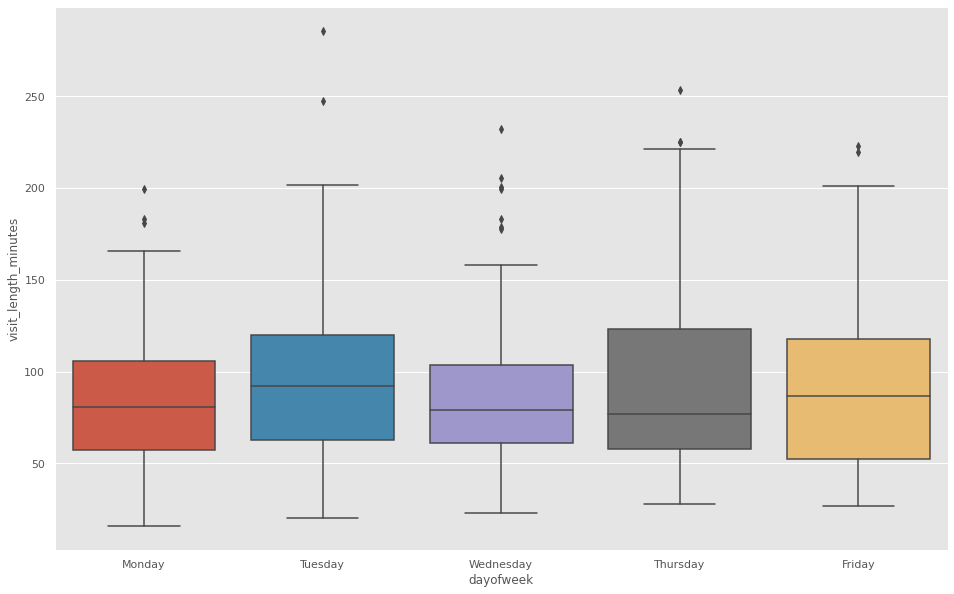

In [350]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] , data=df_final)

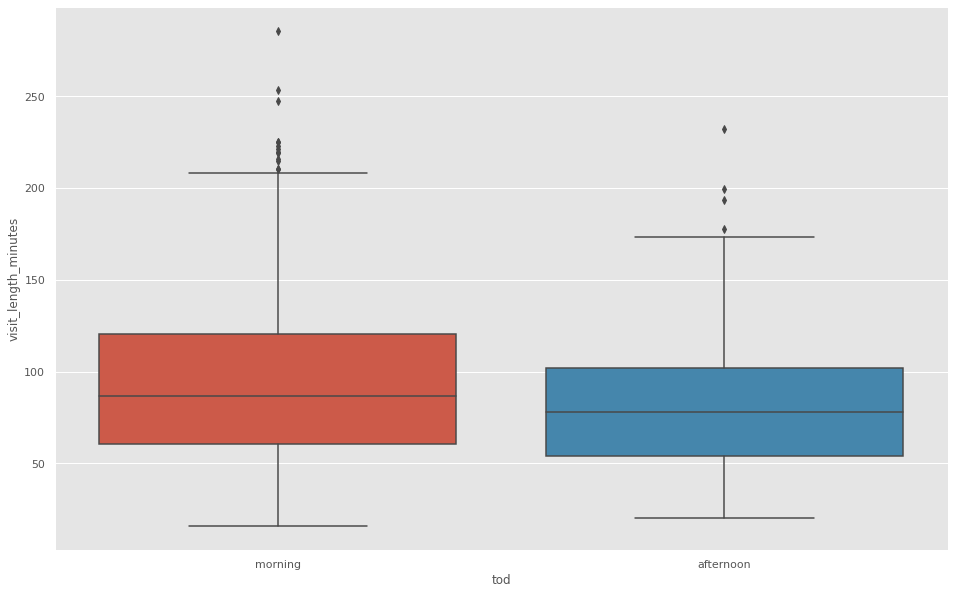

In [351]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

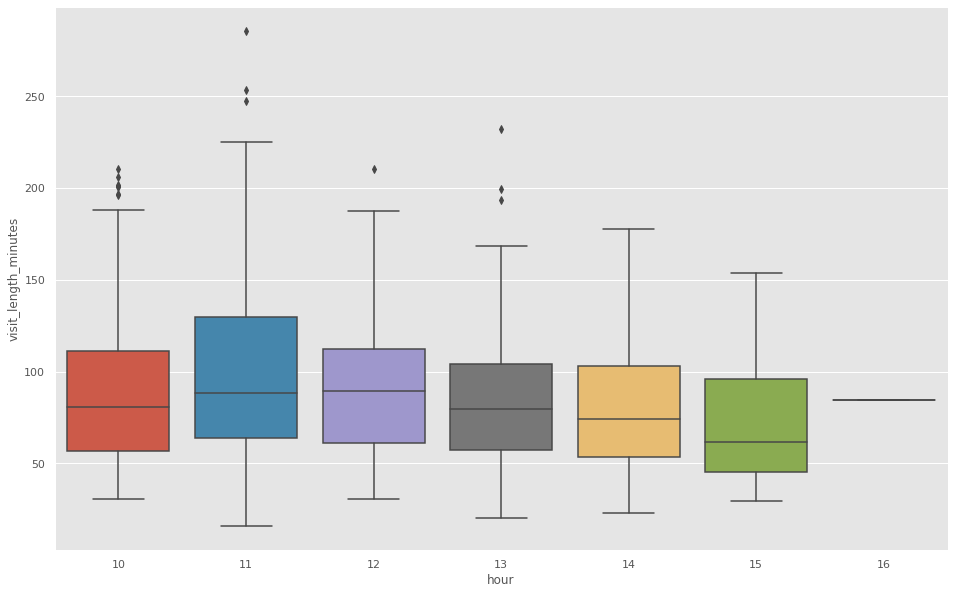

In [352]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

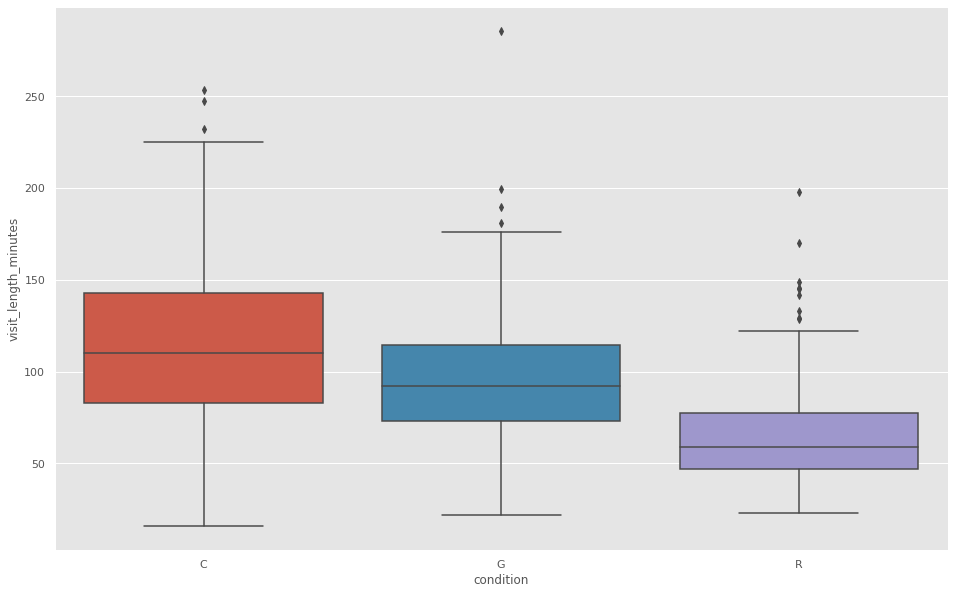

In [353]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

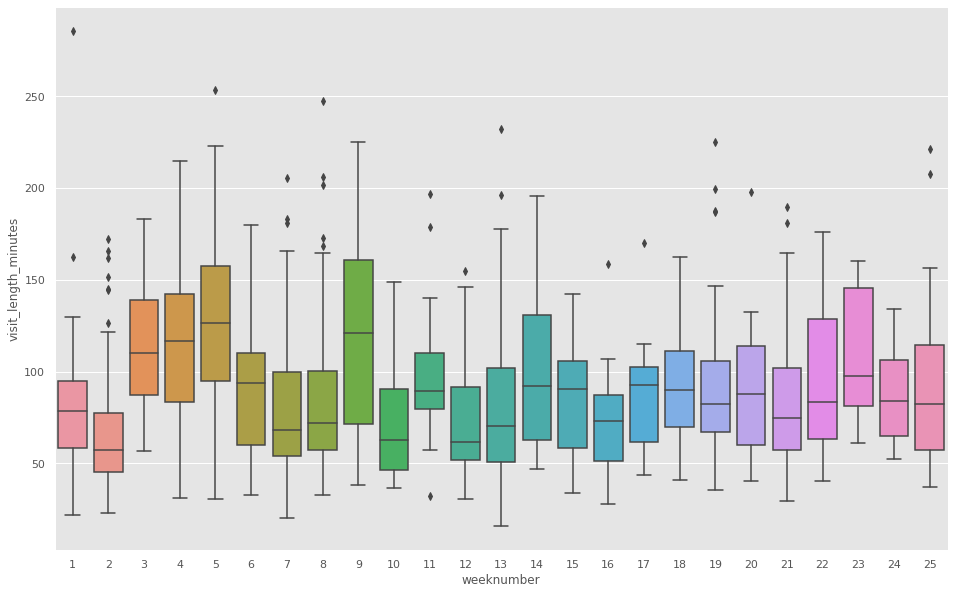

In [354]:
axweeknumber = sns.boxplot(x="weeknumber", y="visit_length_minutes", data=df_final)

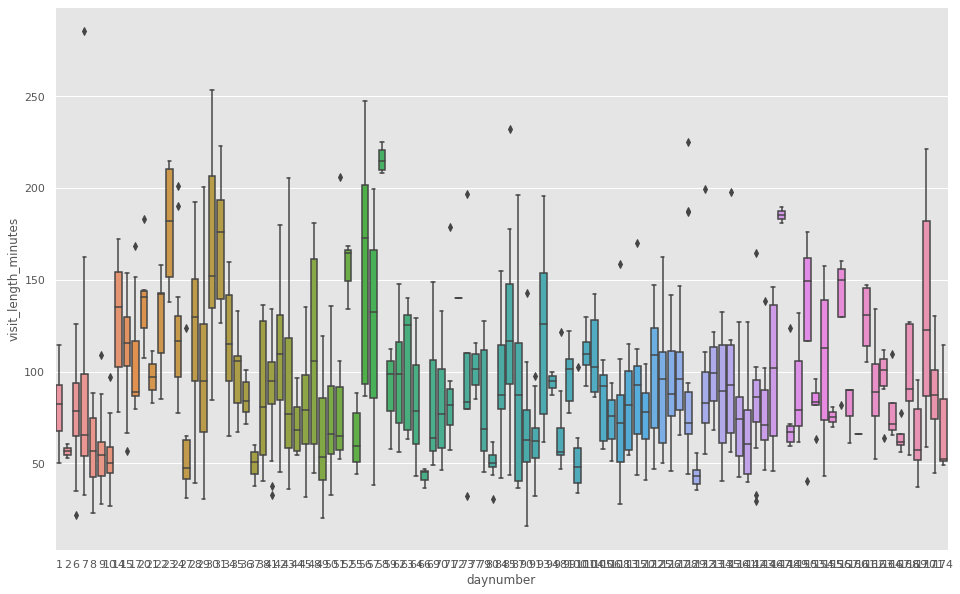

In [355]:
axdaynumber = sns.boxplot(x="daynumber", y="visit_length_minutes", data=df_final)

# Outlier Removal - df_outliers

There are many odd outliers in this data. This section removes these outliers.

In [356]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)] # finds any outliers 3 SD's away from mean
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 0
starttime               0
endtime                 0
xlocation               0
ylocation               0
visit_length            0
dayofweek               0
daynumber               0
weeknumber              0
tod                     0
hour                    0
condition               0
visit_length_minutes    0
dtype: int64


## Removal of 0 Minute Journeys

The section below creates a dataframe where journeys that have a journey time of 0 minutes are removed.

In [357]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
0,C0018,2022-09-20 10:23:24,2022-09-20 12:03:19,19.0810,15.8910,0 days 01:39:55,Tuesday,14,2,morning,10,C,99.9167
1,C0019,2022-09-20 10:27:50,2022-09-20 11:46:02,19.2260,16.8460,0 days 01:18:12,Tuesday,14,2,morning,10,C,78.2000
2,C0020,2022-09-20 10:33:07,2022-09-20 12:16:28,19.2900,15.8190,0 days 01:43:21,Tuesday,14,2,morning,10,C,103.3500
3,C0021,2022-09-20 10:41:53,2022-09-20 12:43:33,19.1800,15.9590,0 days 02:01:40,Tuesday,14,2,morning,10,C,121.6667
4,C0022,2022-09-20 10:46:32,2022-09-20 13:11:30,18.6480,14.9420,0 days 02:24:58,Tuesday,14,2,morning,10,C,144.9667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,R2326,2023-02-24 11:36:16,2023-02-24 13:10:16,1.7410,2.6760,0 days 01:34:00,Friday,171,25,morning,11,R,94.0000
920,R2327,2023-02-24 11:47:32,2023-02-24 13:09:34,0.8860,2.1010,0 days 01:22:02,Friday,171,25,morning,11,R,82.0333
921,R2328,2023-02-27 10:50:44,2023-02-27 11:43:19,2.0070,2.3340,0 days 00:52:35,Monday,174,25,morning,10,R,52.5833
922,R2329,2023-02-27 11:09:15,2023-02-27 11:58:34,4.9260,6.5260,0 days 00:49:19,Monday,174,25,morning,11,R,49.3167


# Start of Final Analysis - df_outlier

In [358]:
mean = df_outliers['visit_length_minutes'].mean()
print(df_outliers['visit_length_minutes'].mean())
print(df_nozero['visit_length_minutes'].mean())

89.50413931436908
89.50413931436908


## Plot all journeys as histogram

Show distribution of patients as histogram and KDE (kernel denisty estimation)

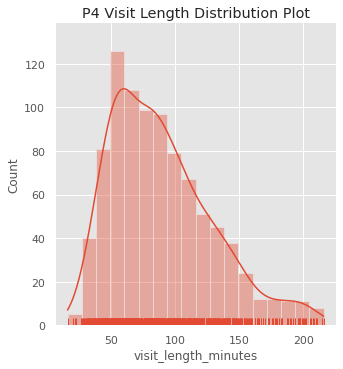

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [359]:
ax = sns.displot(df_outliers['visit_length_minutes'], kde=True, alpha=.4, rug=True)
plt.title('{} Visit Length Distribution Plot'.format(phase))
plt.show()
ax.savefig('{}_visitlength_histogram.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_histogram.png'.format(phase))

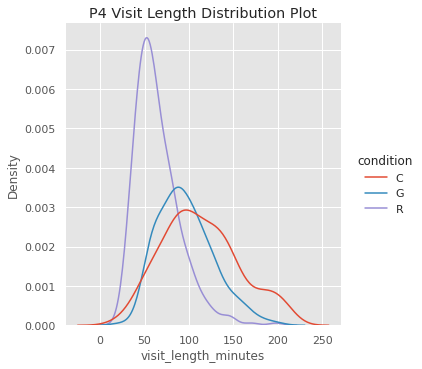

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [360]:
ax = sns.displot(data=df_outliers, x=df_outliers['visit_length_minutes'], hue=df_outliers['condition'], kind="kde")
plt.title('{} Visit Length Distribution Plot'.format(phase))
plt.show()
ax.savefig('{}_visitlength_KDEplot.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_KDEplot.png'.format(phase))

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


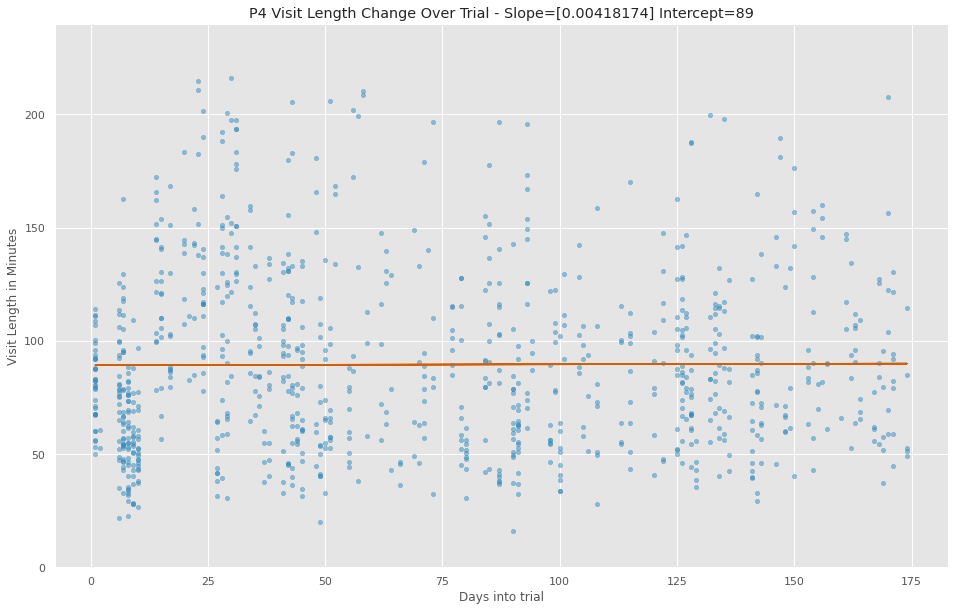

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [361]:
from sklearn.linear_model import LinearRegression
# Creating a Linear Regression model on our data
lin = LinearRegression()
lin.fit(df_outliers[['daynumber']], df_outliers['visit_length_minutes'])
# Creating a plot
ax = df_outliers.plot.scatter(x='daynumber', y='visit_length_minutes', alpha=.5)
ax.plot(df_outliers['daynumber'], lin.predict(df_outliers[['daynumber']]), c='r')
plt.ylim(0, ymax_boxplot)
plt.xlabel('Days into trial')
plt.ylabel('Visit Length in Minutes')
plt.title('{} Visit Length Change Over Trial - Slope={} Intercept={:.0f}'.format(phase, lin.coef_, lin.intercept_))
plt.show()

figure1 = ax.get_figure()
figure1.savefig('{}_visitlength_regresion.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_regresion.png'.format(phase))

In [362]:
#To retrieve the intercept:
print(lin.intercept_)

#For retrieving the slope:
print(lin.coef_)

89.20912963023586
[0.00418174]


## Day of Week Analysis and Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

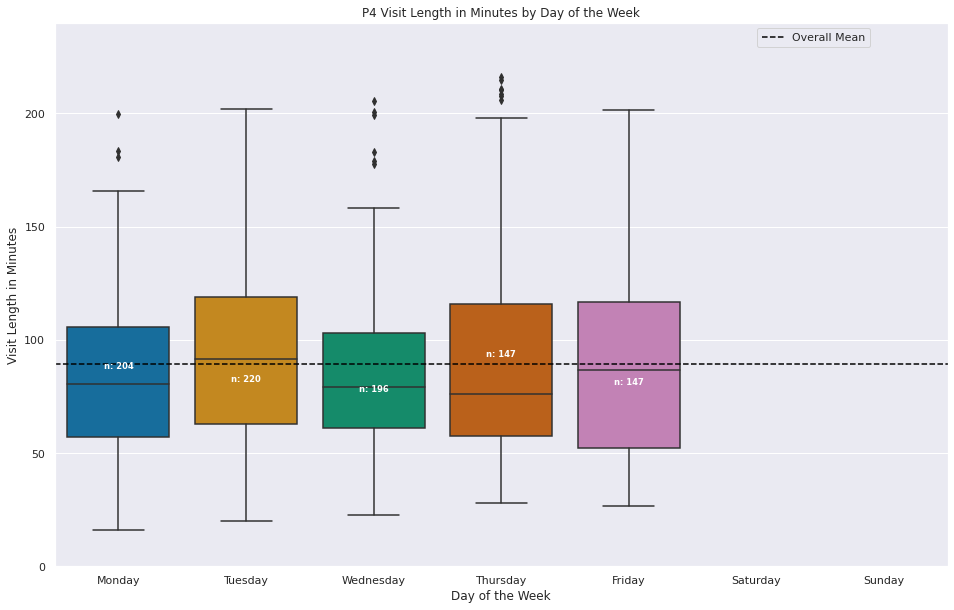

In [363]:
sns.set_style('whitegrid')

sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)

# Calculate number of obs per group & median to position labels
medians = df_outliers.groupby(['dayofweek'])['visit_length_minutes'].median().values
nobs = df_outliers['dayofweek'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,svm.get_xticklabels()):
    svm.text(pos[tick],
            medians[tick] + 1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')


plt.ylim(0, ymax_boxplot)

svm.set_title('{} Visit Length in Minutes by Day of the Week'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength_7dayweek.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_7dayweek.png'.format(phase))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

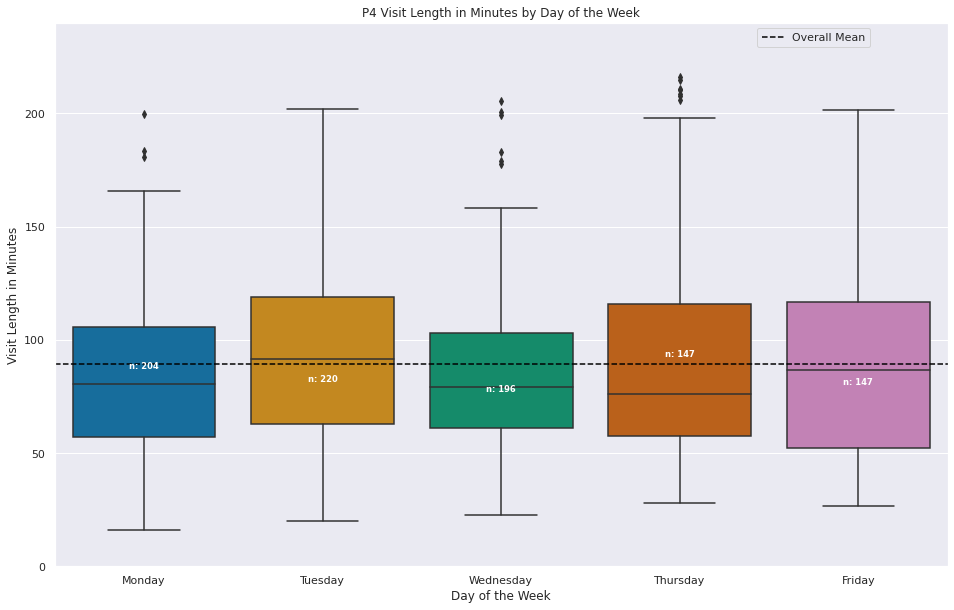

In [364]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)

# Calculate number of obs per group & median to position labels
medians = df_outliers.groupby(['dayofweek'])['visit_length_minutes'].median().values
nobs = df_outliers['dayofweek'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,svm.get_xticklabels()):
    svm.text(pos[tick],
            medians[tick] + 1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')

plt.ylim(0, ymax_boxplot)

svm.set_title('{} Visit Length in Minutes by Day of the Week'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength_5dayweek.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_5dayweek.png'.format(phase))

## Time of Day Analysis and Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

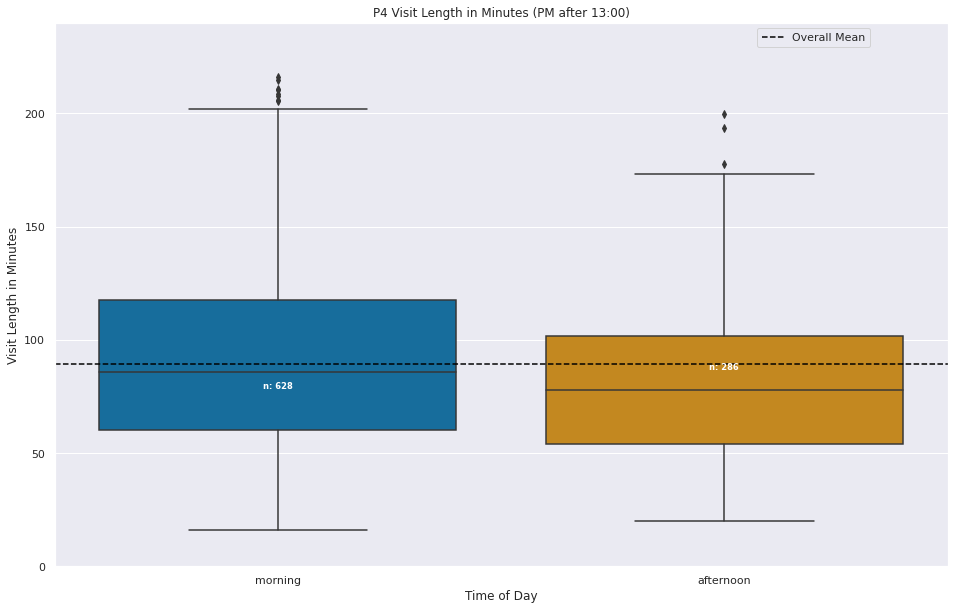

In [365]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

# Calculate number of obs per group & median to position labels
medians = df_outliers.groupby(['tod'])['visit_length_minutes'].median().values
nobs = df_outliers['tod'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,svm.get_xticklabels()):
    svm.text(pos[tick],
            medians[tick] + 1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')

plt.ylim(0, ymax_boxplot)

svm.set_title('{} Visit Length in Minutes (PM after 13:00)'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength_am_pm.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_am_pm.png'.format(phase))

## Condition Analysis and Plots

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

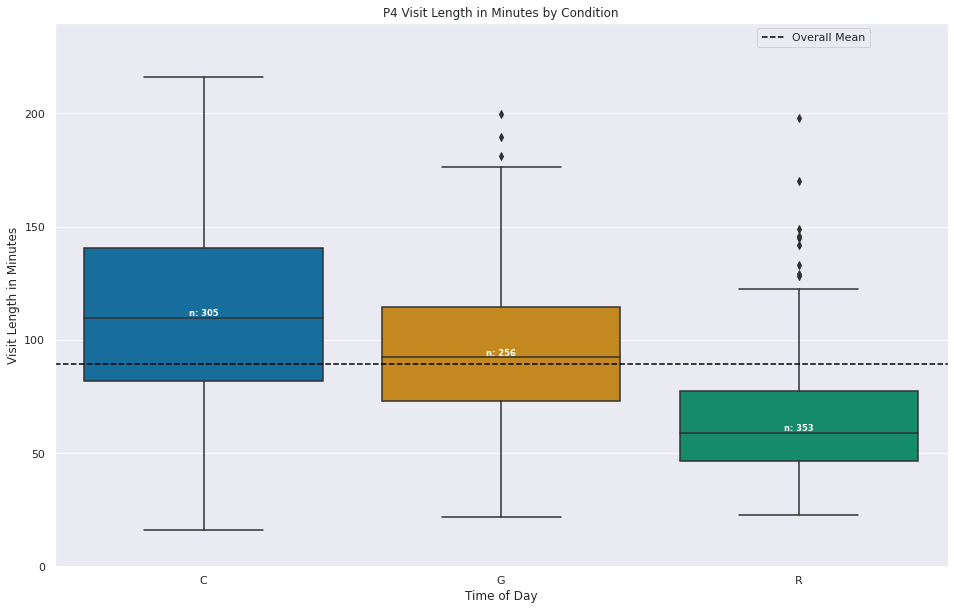

In [366]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

# Calculate number of obs per group & median to position labels
medians = df_outliers.groupby(['condition'])['visit_length_minutes'].median().values
nobs = df_outliers['condition'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,svm.get_xticklabels()):
    svm.text(pos[tick],
            medians[tick] + 1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')

plt.ylim(0, ymax_boxplot)
    
svm.set_title('{} Visit Length in Minutes by Condition'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength_G_R.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_G_R.png'.format(phase))

In [367]:
#axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

## Starting Hour Analysis and Plots

In [368]:
#axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

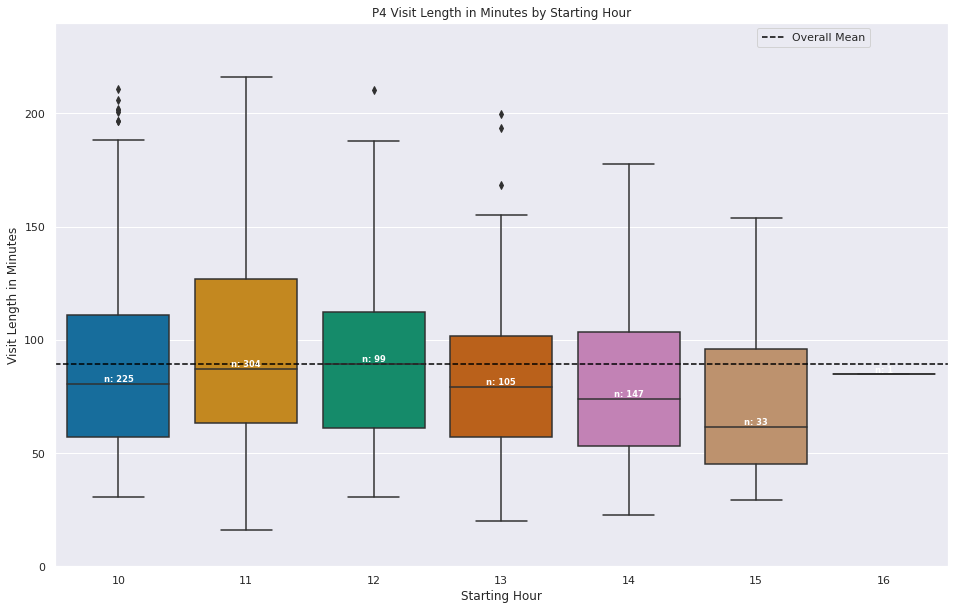

In [369]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

# Calculate number of obs per group & median to position labels
medians = df_outliers.groupby(['hour'])['visit_length_minutes'].median().values
nobs = df_outliers['hour'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,svm.get_xticklabels()):
    svm.text(pos[tick],
            medians[tick] + 1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold')

plt.ylim(0, ymax_boxplot)
    
svm.set_title('{} Visit Length in Minutes by Starting Hour'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength_entryhour.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_entryhour.png'.format(phase))

## Week Numbers

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

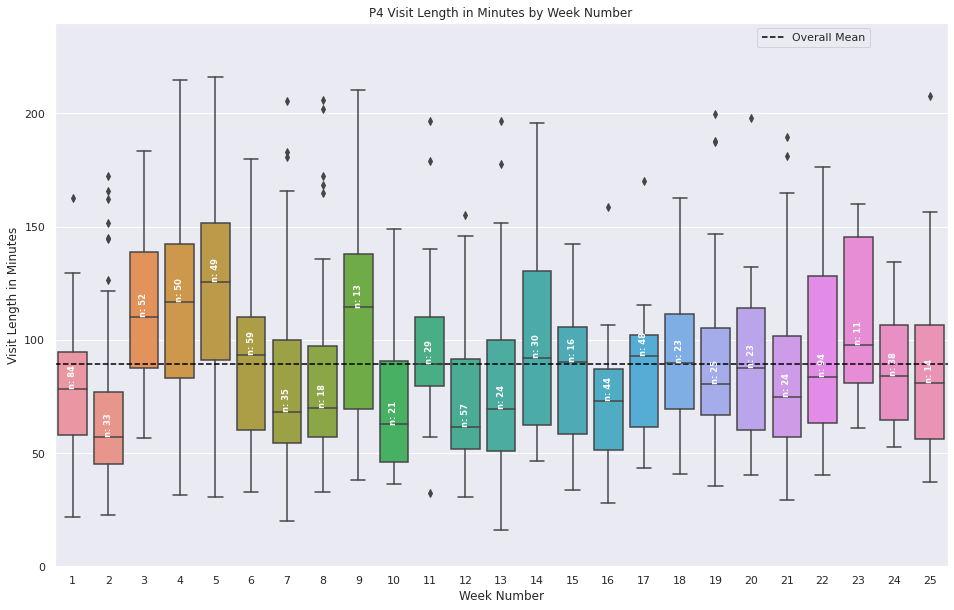

In [370]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(x="weeknumber", y="visit_length_minutes", data=df_outliers)

# Calculate number of obs per group & median to position labels
medians = df_outliers.groupby(['weeknumber'])['visit_length_minutes'].median().values
nobs = df_outliers['weeknumber'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,svm.get_xticklabels()):
    svm.text(pos[tick],
            medians[tick] + 1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold',
            rotation=90)

plt.ylim(0, ymax_boxplot)

svm.set_title('{} Visit Length in Minutes by Week Number'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Week Number')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength_week_number.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_week_number.png'.format(phase))

## Day Numbers

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

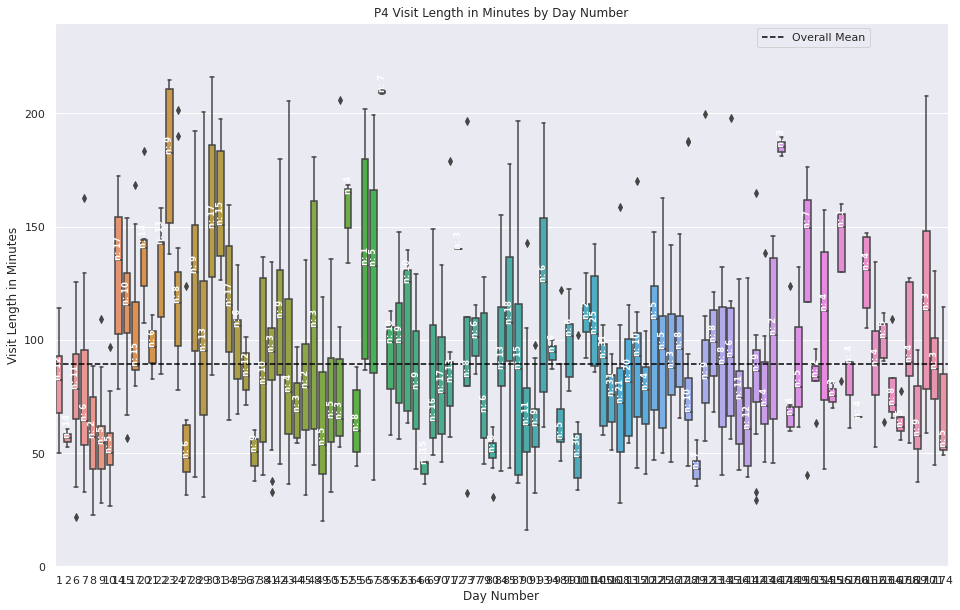

In [371]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(x="daynumber", y="visit_length_minutes", data=df_outliers)

# Calculate number of obs per group & median to position labels
medians = df_outliers.groupby(['daynumber'])['visit_length_minutes'].median().values
nobs = df_outliers['daynumber'].value_counts(sort=False).values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

pos = range(len(nobs))
for tick,label in zip(pos,svm.get_xticklabels()):
    svm.text(pos[tick],
            medians[tick] + 1,
            nobs[tick],
            horizontalalignment='center',
            size='x-small',
            color='w',
            weight='semibold',
            rotation=90)

plt.ylim(0, ymax_boxplot)

svm.set_title('{} Visit Length in Minutes by Day Number'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day Number')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength_day_number.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength_day_number.png'.format(phase))

# Summary Statistics of Each Analysis

The section below gets the summary statistics of each analysis done. These are used in the PowerPoint in the Findings folder in the MS Teams.

In [372]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [373]:
df_outliers['visit_length_minutes'].describe()

count                                   914.0000
mean                                     89.5041
std                                      39.6952
min                                      16.0500
25%                                      58.0417
50%                                      82.2083
75%                                     112.3417
max                                     215.8833
Name: visit_length_minutes, dtype: float64

In [374]:
df_final['visit_length_minutes'].describe()

count                                   924.0000
mean                                     91.0788
std                                      42.3075
min                                      16.0500
25%                                      58.3000
50%                                      82.9583
75%                                     114.3375
max                                     285.3167
Name: visit_length_minutes, dtype: float64

In [375]:
df_final['visit_length_minutes'].median()

82.95833333333334

In [376]:
df_outliers['visit_length'].describe()

count                          914
mean     0 days 01:29:30.248358862
std      0 days 00:39:41.709003016
min                0 days 00:16:03
25%         0 days 00:58:02.500000
50%         0 days 01:22:12.500000
75%         0 days 01:52:20.500000
max                0 days 03:35:53
Name: visit_length, dtype: object

In [377]:
df_final['visit_length'].describe()

count                          924
mean     0 days 01:31:04.729437229
std      0 days 00:42:18.448214855
min                0 days 00:16:03
25%                0 days 00:58:18
50%         0 days 01:22:57.500000
75%         0 days 01:54:20.250000
max                0 days 04:45:19
Name: visit_length, dtype: object

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

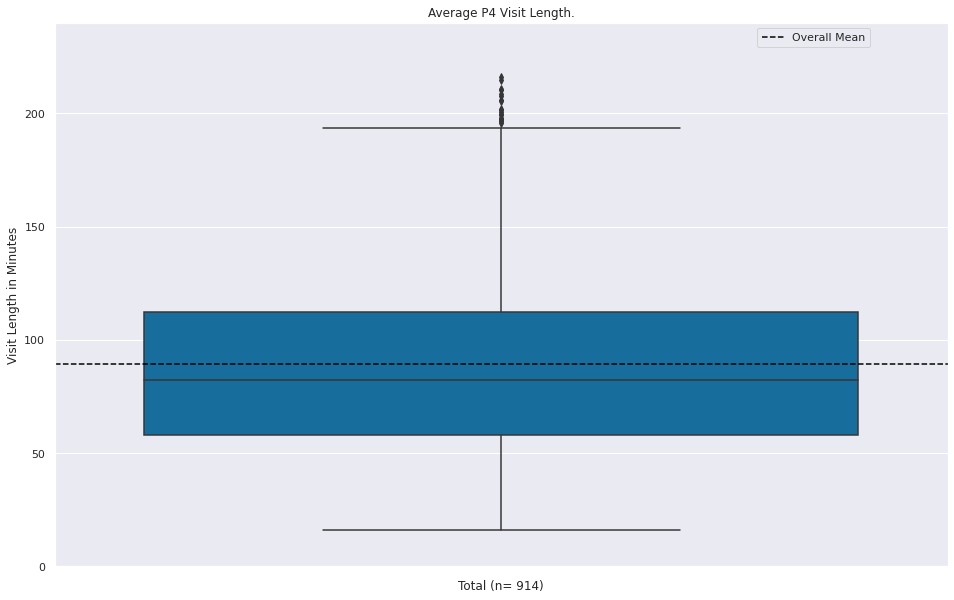

In [378]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(fig_size))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)

# Calculate number of obs 
nobs = df_outliers['Patient'].count()

plt.ylim(0, ymax_boxplot)

svm.set_title('Average {} Visit Length.'.format(phase))
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total (n= {})'.format(nobs))
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('{}_visitlength.png'.format(phase), bbox_inches='tight')
files.download('{}_visitlength.png'.format(phase))

In [379]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
282,C0314,2022-12-05 11:12:56,2022-12-05 11:28:59,4.1380,7.2310,0 days 00:16:03,Monday,90,13,morning,11,C,16.0500
214,C0244,2022-10-25 13:46:04,2022-10-25 14:06:07,4.9260,6.5260,0 days 00:20:03,Tuesday,49,7,afternoon,13,C,20.0500
337,G2968,2022-09-12 11:08:23,2022-09-12 11:30:03,19.0340,15.1300,0 days 00:21:40,Monday,6,1,morning,11,G,21.6667
622,R2021,2022-09-14 14:16:27,2022-09-14 14:39:11,4.9260,6.5260,0 days 00:22:44,Wednesday,8,2,afternoon,14,R,22.7333
662,R2061,2022-09-16 14:54:51,2022-09-16 15:21:31,5.3530,12.7430,0 days 00:26:40,Friday,10,2,afternoon,14,R,26.6667


In [380]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
282,C0314,2022-12-05 11:12:56,2022-12-05 11:28:59,4.1380,7.2310,0 days 00:16:03,Monday,90,13,morning,11,C,16.0500
214,C0244,2022-10-25 13:46:04,2022-10-25 14:06:07,4.9260,6.5260,0 days 00:20:03,Tuesday,49,7,afternoon,13,C,20.0500
337,G2968,2022-09-12 11:08:23,2022-09-12 11:30:03,19.0340,15.1300,0 days 00:21:40,Monday,6,1,morning,11,G,21.6667
622,R2021,2022-09-14 14:16:27,2022-09-14 14:39:11,4.9260,6.5260,0 days 00:22:44,Wednesday,8,2,afternoon,14,R,22.7333
662,R2061,2022-09-16 14:54:51,2022-09-16 15:21:31,5.3530,12.7430,0 days 00:26:40,Friday,10,2,afternoon,14,R,26.6667


In [381]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
105,C0131,2022-10-06 11:05:36,2022-10-06 14:41:29,19.7860,14.8270,0 days 03:35:53,Thursday,30,5,morning,11,C,215.8833
53,C0076,2022-09-29 11:13:57,2022-09-29 14:48:31,19.2170,16.0040,0 days 03:34:34,Thursday,23,4,morning,11,C,214.5667
50,C0073,2022-09-29 10:49:07,2022-09-29 14:19:44,18.8320,14.8520,0 days 03:30:37,Thursday,23,4,morning,10,C,210.6167
245,C0275,2022-11-03 12:05:58,2022-11-03 15:36:13,14.0540,14.6690,0 days 03:30:15,Thursday,58,9,morning,12,C,210.2500
242,C0272,2022-11-03 11:02:48,2022-11-03 14:31:12,18.5730,14.1560,0 days 03:28:24,Thursday,58,9,morning,11,C,208.4000


In [382]:
df_outliers.nlargest(5, 'visit_length')

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
105,C0131,2022-10-06 11:05:36,2022-10-06 14:41:29,19.7860,14.8270,0 days 03:35:53,Thursday,30,5,morning,11,C,215.8833
53,C0076,2022-09-29 11:13:57,2022-09-29 14:48:31,19.2170,16.0040,0 days 03:34:34,Thursday,23,4,morning,11,C,214.5667
50,C0073,2022-09-29 10:49:07,2022-09-29 14:19:44,18.8320,14.8520,0 days 03:30:37,Thursday,23,4,morning,10,C,210.6167
245,C0275,2022-11-03 12:05:58,2022-11-03 15:36:13,14.0540,14.6690,0 days 03:30:15,Thursday,58,9,morning,12,C,210.2500
242,C0272,2022-11-03 11:02:48,2022-11-03 14:31:12,18.5730,14.1560,0 days 03:28:24,Thursday,58,9,morning,11,C,208.4000


In [383]:
df_final.nlargest(20, 'visit_length')

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
362,G2995,2022-09-13 11:12:33,2022-09-13 15:57:52,4.7650,6.4980,0 days 04:45:19,Tuesday,7,1,morning,11,G,285.3167
106,C0132,2022-10-06 11:16:50,2022-10-06 15:30:07,14.0860,16.9230,0 days 04:13:17,Thursday,30,5,morning,11,C,253.2833
239,C0269,2022-11-01 11:23:59,2022-11-01 15:31:14,9.1720,15.3590,0 days 04:07:15,Tuesday,56,8,morning,11,C,247.2500
278,C0310,2022-11-30 13:39:26,2022-11-30 17:31:21,4.9260,6.5260,0 days 03:51:55,Wednesday,85,13,afternoon,13,C,231.9167
243,C0273,2022-11-03 11:14:42,2022-11-03 14:59:40,18.6310,14.7400,0 days 03:44:58,Thursday,58,9,morning,11,C,224.9667
301,C0333,2023-01-12 11:15:15,2023-01-12 15:00:03,4.0610,7.1810,0 days 03:44:48,Thursday,128,19,morning,11,C,224.8000
115,C0141,2022-10-07 11:03:06,2022-10-07 14:45:48,19.0110,15.4060,0 days 03:42:42,Friday,31,5,morning,11,C,222.7000
312,C0346,2023-02-23 11:19:26,2023-02-23 15:00:52,2.2520,2.2850,0 days 03:41:26,Thursday,170,25,morning,11,C,221.4333
116,C0142,2022-10-07 11:04:10,2022-10-07 14:43:37,14.0860,16.9230,0 days 03:39:27,Friday,31,5,morning,11,C,219.4500
244,C0274,2022-11-03 11:26:14,2022-11-03 15:05:10,13.5570,14.9970,0 days 03:38:56,Thursday,58,9,morning,11,C,218.9333


In [384]:
df_outliers.nlargest(20, 'visit_length')

,Patient,starttime,endtime,xlocation,ylocation,visit_length,dayofweek,daynumber,weeknumber,tod,hour,condition,visit_length_minutes
105,C0131,2022-10-06 11:05:36,2022-10-06 14:41:29,19.7860,14.8270,0 days 03:35:53,Thursday,30,5,morning,11,C,215.8833
53,C0076,2022-09-29 11:13:57,2022-09-29 14:48:31,19.2170,16.0040,0 days 03:34:34,Thursday,23,4,morning,11,C,214.5667
50,C0073,2022-09-29 10:49:07,2022-09-29 14:19:44,18.8320,14.8520,0 days 03:30:37,Thursday,23,4,morning,10,C,210.6167
245,C0275,2022-11-03 12:05:58,2022-11-03 15:36:13,14.0540,14.6690,0 days 03:30:15,Thursday,58,9,morning,12,C,210.2500
242,C0272,2022-11-03 11:02:48,2022-11-03 14:31:12,18.5730,14.1560,0 days 03:28:24,Thursday,58,9,morning,11,C,208.4000
313,C0347,2023-02-23 11:42:15,2023-02-23 15:09:41,2.2570,2.8190,0 days 03:27:26,Thursday,170,25,morning,11,C,207.4333
225,C0255,2022-10-27 10:57:44,2022-10-27 14:23:44,19.0480,15.5360,0 days 03:26:00,Thursday,51,8,morning,10,C,206.0000
189,C0217,2022-10-19 11:06:47,2022-10-19 14:32:01,9.7280,16.6420,0 days 03:25:14,Wednesday,43,7,morning,11,C,205.2333
236,C0266,2022-11-01 10:59:59,2022-11-01 14:21:48,13.1660,15.0360,0 days 03:21:49,Tuesday,56,8,morning,10,C,201.8167
58,C0082,2022-09-30 10:35:21,2022-09-30 13:56:40,18.8320,14.8520,0 days 03:21:19,Friday,24,4,morning,10,C,201.3167


# Save results

## CSV Creation

This creates a CSV of the patient journies which can be used for subsequent analysis (e.g. cluster analysis).

In [385]:
phase2df = df_outliers[['Patient', 'starttime', 'endtime', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes']].copy()
phase2df.to_csv('{}_grouped_data.csv'.format(phase), index=False)
files.download('{}_grouped_data.csv'.format(phase))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>